import sys
!{sys.executable} -m pip install music21
!{sys.executable} -m pip install tqdm


In [15]:
import music21
import numpy as np
import glob
import matplotlib.pyplot as plt
import tqdm
import pickle
from keras.utils import np_utils

from keras.models import Sequential
from keras.layers import Activation, Dense, LSTM, Dropout, Flatten, CuDNNLSTM

In [16]:
def encode_song(filename):
    """Encodes song in filename. See milestone1 report for encoding"""
    notesRaw=music21.converter.parse(filename)
    notesRaw=notesRaw.flat.notes

    pitches=[]
    offsets=[]
    
    for note in notesRaw:
        if isinstance(note,music21.note.Note):
            pitches.append(note.pitch.midi)
            offsets.append(note.offset)
        else:
            chordNotes=[int(b.midi) for b in note.pitches]
            pitches.extend(chordNotes)
            offsets.extend([note.offset]*len(chordNotes))

    pitches=np.array(pitches)
    offsets=np.array(offsets)
    uniqueSortedOffsets=np.sort(np.unique(offsets))
    
    encoding=[]
    
    for i in range(len(uniqueSortedOffsets)-1):
        time=uniqueSortedOffsets[i]
        pitchesHere=pitches[offsets==time]
        goforward='gf'+str(uniqueSortedOffsets[i+1]-time)
        
        encoding.extend(list(np.sort(pitchesHere)))
        encoding.append(goforward)
        
        
    
    return encoding   

In [17]:
def decode_song(song,filename):
    """Decodes song encoded by encode_song(). song is an encoded song of type list, and filename is
    the path where the new decoded midi file is to reside"""
    stream=[]
    offset=0
    for event in song:
        if 'gf' in str(event):
            offset+=float(event[2:])
        else:
            newNote=music21.note.Note(int(event))
            newNote.offset=offset
            newNote.storedInstrument=music21.instrument.Piano()
            stream.append(newNote)
    midi_stream=music21.stream.Stream(stream)
    midi_stream.write('midi', fp=filename)
    return 1

In [18]:
FurEliseEncoded=encode_song('Music/beeth/elise.mid')
print(FurEliseEncoded[:50])

[76, 'gf0.25', 75, 'gf0.25', 76, 'gf0.25', 75, 'gf0.25', 76, 'gf0.25', 71, 'gf0.25', 74, 'gf0.25', 72, 'gf0.25', 45, 69, 'gf0.25', 52, 'gf0.25', 57, 'gf0.25', 60, 'gf0.25', 64, 'gf0.25', 69, 'gf0.25', 40, 71, 'gf0.25', 52, 'gf0.25', 56, 'gf0.25', 64, 'gf0.25', 68, 'gf0.25', 71, 'gf0.25', 45, 72, 'gf0.25', 52, 'gf0.25', 57, 'gf0.25', 64]


In [19]:
with open('encodings/information.pickle','rb') as file:
    DF=pickle.load(file)

In [20]:
DF.head()

,SongName,Artist,ModedEncoded
0,alb_esp1.mid,albeniz,"[57, 81, gf0.5, 64, 88, gf3.25, 62, 86, gf0.08..."
1,alb_esp2.mid,albeniz,"[38, 50, gf0.75, 57, gf0.25, 62, 66, 69, gf0.5..."
2,alb_esp3.mid,albeniz,"[59, 71, gf0.5, 63, 75, gf0.5, 66, 78, gf0.5, ..."
3,alb_esp4.mid,albeniz,"[79, gf0.5, 71, 74, gf0.5, 72, 75, gf0.5, 69, ..."
4,alb_esp5.mid,albeniz,"[51, 58, gf0.5, 58, gf1.0, 58, gf0.5, 51, 58, ..."


In [21]:
#checking artists counts:
DF.Artist.value_counts()

chopin         48
schubert       29
beeth          29
schumann       24
haydn          21
grieg          16
liszt          16
mendelssohn    15
albeniz        14
tschai         12
brahms         10
debussy         9
burgm           9
borodin         7
bach            3
granados        3
balakir         1
Name: Artist, dtype: int64

In [22]:
#we begin by getting the vocab of he representation (i.e. all possible events occuring)

vocab=[]
for i in tqdm.tqdm(range(len(DF))):
    vocab.extend(DF.iloc[i,2])
    vocab=list(set(vocab))
with open('SavedModels/vocab.pickle','wb') as file:
    pickle.dump(vocab,file)
    
print('The vocabulary has {} elements'.format(str(len(vocab))))



100%|██████████| 266/266 [00:00<00:00, 4482.46it/s]

The vocabulary has 138 elements


In [23]:
#we now represent each event as a number. We provide dictionaries that transform
#an event into a number, and another which is its inverse.

EventToNumber={}
NumberToEvent={}

for i,word in enumerate(vocab):
    EventToNumber[word]=i
    NumberToEvent[i]=word

with open('SavedModels/EventToNumber.pickle','wb') as file:
    pickle.dump(EventToNumber,file)

with open('SavedModels/NumberToEvent.pickle','wb') as file:
    pickle.dump(NumberToEvent,file)
 

In [24]:
def prepare_sequences(DF,n_vocab,EventToNumber,sequence_length=50):
    network_input = []
    network_output = []
    
    for j in tqdm.tqdm(range(len(DF))):
        song=DF.iloc[j,2]
        # create input sequences and the corresponding outputs
        
        for i in range(0, len(song) - sequence_length, 1):
            sequence_in = song[i: i + sequence_length]
            sequence_out = song[i + sequence_length]
            network_input.append([EventToNumber[char] for char in sequence_in])
            network_output.append(EventToNumber[sequence_out])
    
    
    n_patterns = len(network_input)
    
    # reshape the input into a format comatible with LSTM layers 
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    
    # normalize input
    network_input = network_input / float(n_vocab)
    
    # one hot encode the output vectors
    network_output = np_utils.to_categorical(network_output,num_classes=n_vocab)

    
    return (network_input,network_output)


In [25]:
inp,out=prepare_sequences(DF.iloc[[0],:],len(vocab),EventToNumber)

100%|██████████| 1/1 [00:00<00:00, 187.73it/s]


In [26]:
#check that the shapes look right:
print(inp.shape)
print(out.shape)

(953, 50, 1)
(953, 138)


In [33]:
def create_network(network_in, n_vocab): 
    """Create the model architecture"""
    model = Sequential()
    model.add(CuDNNLSTM(50,input_shape=network_in.shape[1:], return_sequences=True))
    #model.add(Dropout(0.3))
    model.add(CuDNNLSTM(50,return_sequences=True))
    model.add(Flatten())
    model.add(Dense(50))
    #model.add(Dropout(0.3))
    model.add(Dense(50))
    #model.add(Dropout(0.3))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

    return model

In [62]:
from keras.callbacks import ModelCheckpoint
def train_network(model, network_input, network_output, epochs=10,modelName='_'): 
    """
    Train the neural network
    """
    # Create checkpoint to save the best model weights.
    filepath = 'SavedModels/weights.simpleMode{}.hdf5'.format(modelName)
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True)
    
    model.fit(network_input, network_output, epochs=epochs, batch_size=1000, callbacks=[checkpoint])

In [63]:
#we look into only using bach Music:
DF_mendelssohn=DF[DF['Artist']=='mendelssohn']
DF_mendelssohn_train=DF_mendelssohn.iloc[:-1,:]
DF_mendelssohn_test=DF_mendelssohn.iloc[[-1],:]


net_inputs,net_outputs=prepare_sequences(DF_mendelssohn_train,len(vocab), EventToNumber)
print('Prepared Input and ouput Sequences')

model=create_network(net_inputs,len(vocab))
print('Network Prepared, training next')

train_network(model,net_inputs,net_outputs,epochs=500,modelName='TEST')


100%|██████████| 14/14 [00:00<00:00, 89.05it/s]


Prepared Input and ouput Sequences
Network Prepared, training next
Epoch 1/500
27869/27869 [==============================] - 3s 100us/step - loss: 4.0985 - acc: 0.1236
Epoch 2/500
27869/27869 [==============================] - 1s 33us/step - loss: 3.6506 - acc: 0.1466
Epoch 3/500
27869/27869 [==============================] - 1s 33us/step - loss: 3.6282 - acc: 0.1488
Epoch 4/500
27869/27869 [==============================] - 1s 33us/step - loss: 3.6063 - acc: 0.1728
Epoch 5/500
27869/27869 [==============================] - 1s 33us/step - loss: 3.5817 - acc: 0.1800
Epoch 6/500
27869/27869 [==============================] - 1s 33us/step - loss: 3.5692 - acc: 0.1765
Epoch 7/500
27869/27869 [==============================] - 1s 33us/step - loss: 3.5559 - acc: 0.1832
Epoch 8/500
27869/27869 [==============================] - 1s 33us/step - loss: 3.5496 - acc: 0.1846
Epoch 9/500
27869/27869 [==============================] - 1s 33us/step - loss: 3.5430 - acc: 0.1866
Epoch 10/500
27869/2786

27869/27869 [==============================] - 1s 33us/step - loss: 2.0784 - acc: 0.4268
Epoch 81/500
27869/27869 [==============================] - 1s 33us/step - loss: 2.0561 - acc: 0.4318
Epoch 82/500
27869/27869 [==============================] - 1s 33us/step - loss: 2.0419 - acc: 0.4350
Epoch 83/500
27869/27869 [==============================] - 1s 33us/step - loss: 2.0397 - acc: 0.4359
Epoch 84/500
27869/27869 [==============================] - 1s 33us/step - loss: 1.9925 - acc: 0.4471
Epoch 85/500
27869/27869 [==============================] - 1s 34us/step - loss: 1.9823 - acc: 0.4527
Epoch 86/500
27869/27869 [==============================] - 1s 33us/step - loss: 1.9626 - acc: 0.4548
Epoch 87/500
27869/27869 [==============================] - 1s 34us/step - loss: 1.9394 - acc: 0.4597
Epoch 88/500
27869/27869 [==============================] - 1s 33us/step - loss: 1.9303 - acc: 0.4626
Epoch 89/500
27869/27869 [==============================] - 1s 33us/step - loss: 1.9184 - acc: 

27869/27869 [==============================] - 1s 34us/step - loss: 0.8647 - acc: 0.7476
Epoch 160/500
27869/27869 [==============================] - 1s 33us/step - loss: 0.8533 - acc: 0.7511
Epoch 161/500
27869/27869 [==============================] - 1s 34us/step - loss: 0.8500 - acc: 0.7490
Epoch 162/500
27869/27869 [==============================] - 1s 33us/step - loss: 0.8444 - acc: 0.7487
Epoch 163/500
27869/27869 [==============================] - 1s 34us/step - loss: 0.8225 - acc: 0.7579
Epoch 164/500
27869/27869 [==============================] - 1s 34us/step - loss: 0.8014 - acc: 0.7641
Epoch 165/500
27869/27869 [==============================] - 1s 33us/step - loss: 0.7948 - acc: 0.7663
Epoch 166/500
27869/27869 [==============================] - 1s 33us/step - loss: 0.8137 - acc: 0.7557
Epoch 167/500
27869/27869 [==============================] - 1s 34us/step - loss: 0.7871 - acc: 0.7677
Epoch 168/500
27869/27869 [==============================] - 1s 33us/step - loss: 0.769

27869/27869 [==============================] - 1s 33us/step - loss: 0.2453 - acc: 0.9298
Epoch 239/500
27869/27869 [==============================] - 1s 33us/step - loss: 0.2500 - acc: 0.9291
Epoch 240/500
27869/27869 [==============================] - 1s 34us/step - loss: 0.2377 - acc: 0.9328
Epoch 241/500
27869/27869 [==============================] - 1s 33us/step - loss: 0.2322 - acc: 0.9362
Epoch 242/500
27869/27869 [==============================] - 1s 33us/step - loss: 0.2353 - acc: 0.9335
Epoch 243/500
27869/27869 [==============================] - 1s 33us/step - loss: 0.2403 - acc: 0.9299
Epoch 244/500
27869/27869 [==============================] - 1s 33us/step - loss: 0.2404 - acc: 0.9316
Epoch 245/500
27869/27869 [==============================] - 1s 34us/step - loss: 0.2253 - acc: 0.9358
Epoch 246/500
27869/27869 [==============================] - 1s 34us/step - loss: 0.2214 - acc: 0.9358
Epoch 247/500
27869/27869 [==============================] - 1s 33us/step - loss: 0.220

27869/27869 [==============================] - 1s 34us/step - loss: 0.1214 - acc: 0.9663
Epoch 318/500
27869/27869 [==============================] - 1s 33us/step - loss: 0.1259 - acc: 0.9651
Epoch 319/500
27869/27869 [==============================] - 1s 34us/step - loss: 0.1354 - acc: 0.9615
Epoch 320/500
27869/27869 [==============================] - 1s 34us/step - loss: 0.1239 - acc: 0.9645
Epoch 321/500
27869/27869 [==============================] - 1s 34us/step - loss: 0.1185 - acc: 0.9669
Epoch 322/500
27869/27869 [==============================] - 1s 34us/step - loss: 0.1118 - acc: 0.9696
Epoch 323/500
27869/27869 [==============================] - 1s 33us/step - loss: 0.2404 - acc: 0.9268
Epoch 324/500
27869/27869 [==============================] - 1s 33us/step - loss: 0.3790 - acc: 0.8814
Epoch 325/500
27869/27869 [==============================] - 1s 33us/step - loss: 0.2044 - acc: 0.9343
Epoch 326/500
27869/27869 [==============================] - 1s 33us/step - loss: 0.138

27869/27869 [==============================] - 1s 34us/step - loss: 0.1007 - acc: 0.9723
Epoch 397/500
27869/27869 [==============================] - 1s 34us/step - loss: 0.1068 - acc: 0.9700
Epoch 398/500
27869/27869 [==============================] - 1s 34us/step - loss: 0.0942 - acc: 0.9752
Epoch 399/500
27869/27869 [==============================] - 1s 34us/step - loss: 0.0986 - acc: 0.9730
Epoch 400/500
27869/27869 [==============================] - 1s 34us/step - loss: 0.1059 - acc: 0.9693
Epoch 401/500
27869/27869 [==============================] - 1s 34us/step - loss: 0.1126 - acc: 0.9680
Epoch 402/500
27869/27869 [==============================] - 1s 34us/step - loss: 0.1071 - acc: 0.9697
Epoch 403/500
27869/27869 [==============================] - 1s 34us/step - loss: 0.2338 - acc: 0.9277
Epoch 404/500
27869/27869 [==============================] - 1s 33us/step - loss: 0.2079 - acc: 0.9323
Epoch 405/500
27869/27869 [==============================] - 1s 34us/step - loss: 0.151

27869/27869 [==============================] - 1s 34us/step - loss: 0.0750 - acc: 0.9805
Epoch 476/500
27869/27869 [==============================] - 1s 33us/step - loss: 0.0778 - acc: 0.9813
Epoch 477/500
27869/27869 [==============================] - 1s 33us/step - loss: 0.0704 - acc: 0.9821
Epoch 478/500
27869/27869 [==============================] - 1s 34us/step - loss: 0.0739 - acc: 0.9813
Epoch 479/500
27869/27869 [==============================] - 1s 33us/step - loss: 0.0712 - acc: 0.9820
Epoch 480/500
27869/27869 [==============================] - 1s 34us/step - loss: 0.0802 - acc: 0.9785
Epoch 481/500
27869/27869 [==============================] - 1s 33us/step - loss: 0.1089 - acc: 0.9693
Epoch 482/500
27869/27869 [==============================] - 1s 33us/step - loss: 0.1033 - acc: 0.9708
Epoch 483/500
27869/27869 [==============================] - 1s 34us/step - loss: 0.0855 - acc: 0.9770
Epoch 484/500
27869/27869 [==============================] - 1s 34us/step - loss: 0.077

In [37]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_5 (CuDNNLSTM)     (None, 50, 50)            10600     
_________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)     (None, 50, 50)            20400     
_________________________________________________________________
flatten_4 (Flatten)          (None, 2500)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 50)                125050    
_________________________________________________________________
dense_11 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_12 (Dense)             (None, 138)               7038      
_________________________________________________________________
activation_4 (Activation)    (None, 138)               0         
Total para

In [69]:
#we now see how the model does on the unseen Song by mendelssohn:
net_inputs_test,net_outputs_test=prepare_sequences(DF_mendelssohn_test,len(vocab), EventToNumber)
model.evaluate(net_inputs_test,net_outputs_test)


100%|██████████| 1/1 [00:00<00:00, 130.04it/s]

 704/1371 [==============>...............] - ETA: 0s

1371/1371 [==============================] - 0s 243us/step


[11.695584288832917, 0.1626549962443387]

In [79]:
#the model is guessing the correct value 16 percent of the times. We would like to get a better idea of what the model
#is doing. i.e. is only guessing one very frequent note?

modelOutput=model.predict(net_inputs_test)

notesOutput=[]

for i in range(len(modelOutput)):
    notesOutput.append(NumberToEvent[np.argmax(modelOutput[i,:])])
    

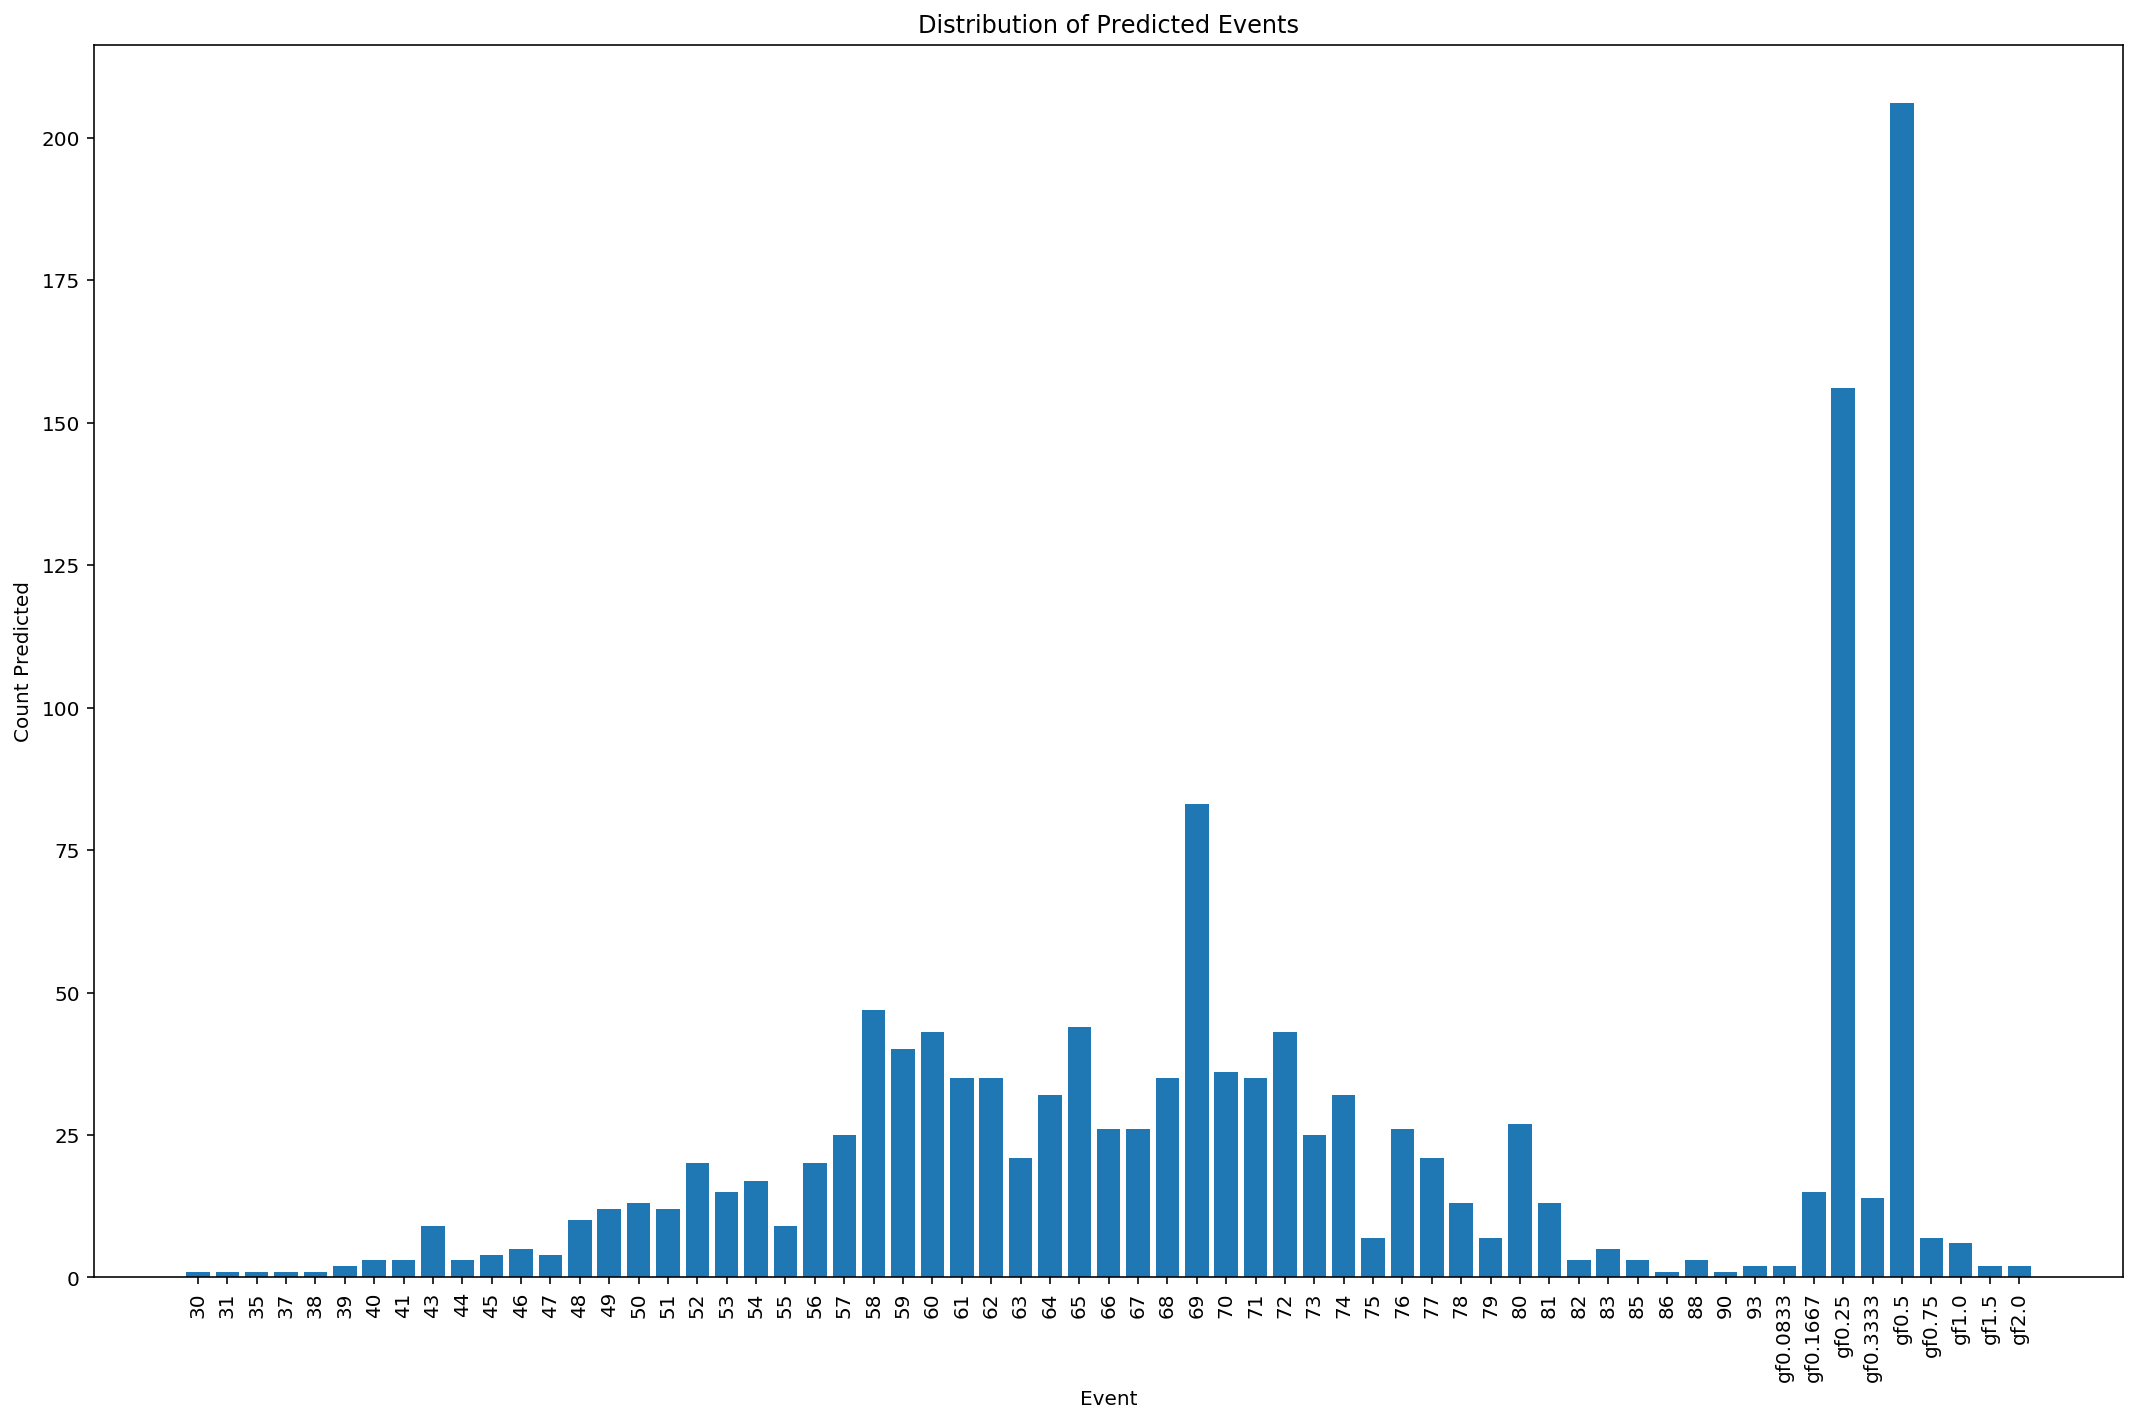

In [94]:
x,y=np.unique(notesOutput,return_counts=True)

fig=plt.figure(figsize=(15,10))
plt.bar(x,y)
plt.xticks(rotation=90)
plt.title('Distribution of Predicted Events')
plt.xlabel('Event')
plt.ylabel('Count Predicted')
plt.tight_layout()
plt.savefig('figures/predictionDistribution.png')
plt.show()

In [141]:
def generate_music(model,input_sequence,NumberEventsToGenerate,file_name,NumberToEvent,vocab=vocab):
    song=list(np.reshape(input_sequence,(50,)))
    for i in range(NumberEventsToGenerate):
        nextNote=model.predict(np.reshape(song[i:i+50],(1,50,1)))
        nextNote=np.argmax(nextNote)/len(vocab)
        song.append(nextNote)
     
    song=np.round(np.array(song)*len(vocab))
    
    translatedSong=[]
    for word in song:
        translatedSong.append(NumberToEvent[int(word)])
    
    write=decode_song(translatedSong,file_name)
    
    
    return translatedSong

In [149]:
#we generate using a sequence from the training data
indices=np.random.choice(np.arange(0,20000),size=30,replace=False)

for i in range(30):

    new=generate_music(model,net_inputs[indices[i],:,:].reshape((1,50,1)),\
                       500,file_name='Samples/Mendehlsson_TrainingDataSample{}.mid'.format(str(i+1)),\
                       NumberToEvent=NumberToEvent,vocab=vocab)

In [150]:
#we generate using a sequence from the test data
indices=np.random.choice(np.arange(0,1000),size=30,replace=False)

for i in range(30):

    new=generate_music(model,net_inputs_test[indices[i],:,:].reshape((1,50,1)),\
                       500,file_name='Samples/Mendehlsson_TestingDataSample{}.mid'.format(str(i+1)),\
                       NumberToEvent=NumberToEvent,vocab=vocab)